In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torchvision.transforms as transforms
import os
import shutil
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import random
import torchvision.models as models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from PIL import Image
from PIL import ImageOps

In [2]:
class ResizeByLongerSideWithRatio:
    def __init__(self, size, fill_color=0):
        self.size = size  # The fixed size for the longer side
        self.fill_color = fill_color  # Padding color (default: black)

    def __call__(self, image):
        w, h = image.size  # Get original width and height
        ratio = w/h
        target_w, target_h = self.size
        target_ratio = target_w/target_h
        if target_ratio <= ratio:
            # Scale height to maintain aspect ratio
            new_w, new_h = target_w, int((h/w)*target_w)
            padding_h = target_h-new_h
            padding_w = 0
        
        else:
            # Scale width to maintain aspect ratio
            new_w, new_h = int((w/h)*target_h), target_h
            padding_w = target_w - new_w
            padding_h = 0
        # Resize the image
        
        #image = self.binarize(image)
        
        image = image.resize((new_w, new_h))
        
        left = random.randint(0,padding_w)
        top = random.randint(0,padding_h)
        right = padding_w-left
        bot = padding_h-top
        padding = (left,top,right,bot)
        
        image = ImageOps.expand(image, border=padding, fill=self.fill_color)
        return image
    def binarize(self, image):
        image = np.array(image)
        image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        
        image_gray = cv2.medianBlur(image_gray,5)
        image_gray = cv2.normalize(image_gray, None, alpha=0, beta=350, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        BLOCK_SIZE = 11
        CONSTANT = 10
        
        image = cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,BLOCK_SIZE,CONSTANT)
        image = Image.fromarray(image.astype(np.uint8))
        
        return image
   

In [3]:

#from CustomTransforms import ResizeByLongerSideWithRatio
train_transform = transforms.Compose([
    ResizeByLongerSideWithRatio(size=(224,224)),  # Resize based on longer side
    transforms.ToTensor(),
    transforms.RandomApply([transforms.GaussianBlur(5)], p=0.3),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize
])

val_transform = transforms.Compose([
    ResizeByLongerSideWithRatio(size=(224,224)),  # Resize based on longer side
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize
])

In [4]:

"""
def remove_checkpoints(base_dir):
    for root, dirs, _ in os.walk(base_dir):
        for folder in dirs:
            if folder == ".ipynb_checkpoints":
                folder_path = os.path.join(root, folder)
                shutil.rmtree(folder_path)
                print(f"Removed: {folder_path}")

# Replace with your dataset directory
data_dir = "cross_out_dataset"
remove_checkpoints(data_dir)
"""

'\ndef remove_checkpoints(base_dir):\n    for root, dirs, _ in os.walk(base_dir):\n        for folder in dirs:\n            if folder == ".ipynb_checkpoints":\n                folder_path = os.path.join(root, folder)\n                shutil.rmtree(folder_path)\n                print(f"Removed: {folder_path}")\n\n# Replace with your dataset directory\ndata_dir = "cross_out_dataset"\nremove_checkpoints(data_dir)\n'

In [5]:


class FilteredImageFolder(Dataset):
    def __init__(self, root, transform=None, min_size=50):
        self.root_dir = root        
        self.transform = transform
        self.min_size = min_size
        self.image_paths, self.labels = self._filter_and_label_images()

    def _filter_and_label_images(self):
        image_paths = []
        labels = []
        class_names = sorted(os.listdir(self.root_dir))  # Get folder names as labels
        class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name in class_names:
            class_dir = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue  # Skip non-folder files

            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                try:
                    img = Image.open(img_path)
                    width, height = img.size
                    if width >= self.min_size and height >= self.min_size:
                        image_paths.append(img_path)
                        labels.append(class_to_idx[class_name])  # Assign label based on folder
                except:
                    print(f"Skipping corrupted file: {img_path}")

        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)

        return img, label  # Returning (image, label) tuple

In [6]:

data_dir = "cross_out_dataset"  # Update this with your dataset path

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train/images", transform=train_transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val/images", transform=val_transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test/images", transform=val_transform)


In [7]:
"""
from PIL import Image

for root, _, files in os.walk("cross_out_dataset/val/images"):
    for file in files:
        try:
            Image.open(os.path.join(root, file)).verify()
        except Exception as e:
            print(f"Corrupted file: {file} - {e}")
"""

'\nfrom PIL import Image\n\nfor root, _, files in os.walk("cross_out_dataset/val/images"):\n    for file in files:\n        try:\n            Image.open(os.path.join(root, file)).verify()\n        except Exception as e:\n            print(f"Corrupted file: {file} - {e}")\n'

In [8]:
print("Class to Index Mapping:")
#print(val_dataset.class_to_idx)


Class to Index Mapping:


In [10]:
import wandb
wandb.init(project="Group_19_lab1",name="224x224_kernel3x7_stride1x2_padding1x3_avgpool_blur_rotation_removeNone_scheduler")


893
0
torch.Size([3, 224, 224])


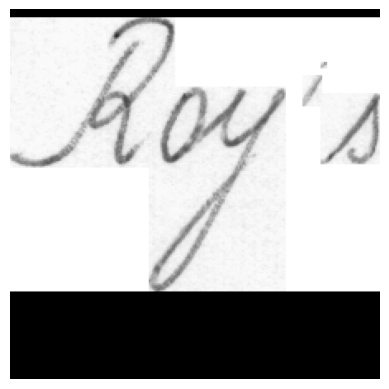

In [11]:
# Access one image and its label from the dataset

i = random.randint(0,1000)

print(i)
image, label = train_dataset[i]  # Get the first image-label pair
print(label)
print(image.shape)
# Denormalize the image for visualization (convert back to [0,1] range)
image = image * 0.5 + 0.5  # Reverse normalization

# Display the image
plt.imshow(image.permute(1, 2, 0))  # Permute tensor dimensions (C, H, W → H, W, C)
plt.axis("off")  # Turn off axes for clarity
plt.show()

In [12]:
BATCH_SIZE = 64
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 390650, Validation: 61808, Test: 188396


In [13]:
import torch.nn as nn

def replace_all_conv_layers(model, new_kernel_size=(3,7), new_stride=(1,2), new_padding=(1,3)):
    for name, module in model.named_children():
        # Recursively go inside submodules
        if isinstance(module, nn.Conv2d):
            # Replace the conv layer with the new one
            new_conv = nn.Conv2d(
                in_channels=module.in_channels,
                out_channels=module.out_channels,
                kernel_size=new_kernel_size,
                stride=new_stride,
                padding=new_padding,
                bias=module.bias is not None
            )
            setattr(model, name, new_conv)
        else:
            # Recursively apply to child modules
            replace_all_conv_layers(module, new_kernel_size, new_stride, new_padding)

    return model



In [18]:


# Load ResNet18 pretrained model
model = models.resnet18(pretrained=True)

# Modify the fully connected layer for 8 classes
num_classes = 8
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Check the model architecture

# Modify the first convolutional layer to accept single-channel input
#model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#model = replace_all_conv_layers(model)
model.conv1 = nn.Conv2d(3, 64, kernel_size=(3,7), stride=(1,2), padding=(1,3), bias=False)
#model.maxpool = nn.AvgPool2d(kernel_size=2, stride=2)
model.maxpool = nn.AvgPool2d(2,2)

In [19]:
import torch
print(torch.cuda.is_available())  # Returns True if a GPU is available
# Specify the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model to the device
model = model.to(device)

True


In [20]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
epochs = 10
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=epochs
)


for epoch in range(epochs):
    tot_train_loss = 0
    tot_val_loss = 0
    total_samples = 0
    model.train()
    batch_id = 0
    best_val_loss = 100000
    for batch in train_loader:
        

        inp = batch[0].to(device)
        label = batch[1].to(device)
        output = model(inp)

        loss = criterion(output,label)
        tot_train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        scheduler.step()
        total_samples += inp.size(0)
        if batch_id%10 == 0:
            print(f"\rTrain samples ran: {total_samples}/{len(train_dataset)}",end="",flush=True)
        batch_id += 1
    model.eval()
    total_samples = 0
    batch_id = 0
    for batch in val_loader:
        optimizer.zero_grad()

        inp = batch[0].to(device)
        label = batch[1].to(device)
        output = model(inp)

        loss = criterion(output,label)
        tot_val_loss += loss.item()
        
    avg_train_loss = tot_train_loss/len(train_loader)
    avg_val_loss = tot_val_loss/len(val_loader)
    print("Epoch: ",epoch,"Train loss: ",avg_train_loss,"Val loss: ",avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_model = model
        best_val_loss = avg_val_loss
    print()
    current_lr = optimizer.param_groups[0]['lr']
    print("Current lr: ", current_lr)
    wandb.log({
        "train_loss":avg_train_loss,
        "val_loss":avg_val_loss,
        "lr": current_lr
    })
    torch.cuda.empty_cache()

Train samples ran: 390464/390650Epoch:  0 Train loss:  0.360154881953783 Val loss:  0.38791525617288136

Current lr:  0.0002800237736351826
Train samples ran: 390464/390650Epoch:  1 Train loss:  0.29094410250830033 Val loss:  0.3086218031674747

Current lr:  0.0007600475449154247
Train samples ran: 390464/390650Epoch:  2 Train loss:  0.26910054304595515 Val loss:  2.4435613784923627

Current lr:  0.00099999999864851
Train samples ran: 390464/390650Epoch:  3 Train loss:  0.24890950550648674 Val loss:  0.2772786941872929

Current lr:  0.0009504686801251417
Train samples ran: 390464/390650Epoch:  4 Train loss:  0.23516181980254833 Val loss:  0.47019693116208167

Current lr:  0.0008117169109917103
Train samples ran: 234304/390650

In [20]:
torch.save(best_model, "")

In [37]:
import torch
model = torch.load("resnet18_moving_fit_to_aspect_ratio_224_224_scheduler_BEST.pth",weights_only=False)

In [38]:

total = 0
correct = 0
wrong_guess = []
missed_image = []
for i in range(8):
    wrong_guess.append([])
    missed_image.append([])

model.eval()
print(len(val_dataset))
print(len(train_loader))
tot_val_loss = 0
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch[0].to(device)           # Move input_ids to GPU/CPU     
        labels = batch[1].to(device)              # Move labels to GPU/CPU
        output = model(input_ids)
        loss = criterion(output,labels)
        #tot_val_loss += loss.item()
        for i in range(len(output)):
            o = torch.argmax(output[i]).item()
            #label = labels[i].item()
            total += 1
            if total % 1000 == 0:
                print(total)
            if  o == label:
                correct += 1
            else:
                pass
                #missed_image[label].append(input_ids[i].cpu().tolist())
                #wrong_guess[label].append(o)
print("Acc: ",correct/total)
print("Loss: ",tot_val_loss/len(val_loader))

51649
6104
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
Acc:  0.12151251718329494
Loss:  0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


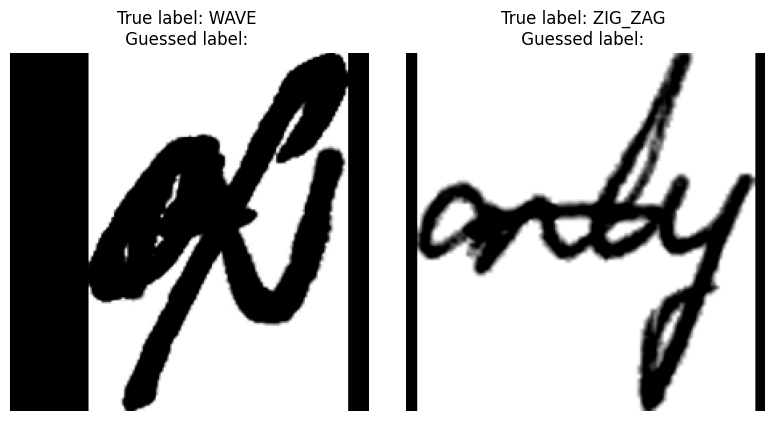

0
0
0
0
0
0
4
3


In [25]:
import matplotlib.pyplot as plt
import random

# Example: image_lists = [[img1_class0, img2_class0, ...], [img1_class1, img2_class1, ...], ...]

import numpy as np

def plot_random_images(image_lists, class_labels):
    num_classes = len(image_lists)
    cols = 4  # number of columns
    rows = (num_classes + cols - 1) // cols  # calculate rows

    plt.figure(figsize=(4 * cols, 4 * rows))
    
    for i, (images, label) in enumerate(zip(image_lists, class_labels)):
        if len(images)>0:
            random_image = random.choice(images)
            random_image = np.array(random_image)
        # If image is a tensor, move to CPU and convert to numpy
            if hasattr(random_image, 'cpu'):
                random_image = random_image.cpu().numpy()
                
            
            # If image has shape (C, H, W), transpose to (H, W, C)
            if random_image.ndim == 3 and random_image.shape[0] in [1, 3]:
                random_image = np.transpose(random_image, (1, 2, 0))
            
            plt.subplot(rows, cols, i + 1)
            if random_image.ndim == 2 or random_image.shape[2] == 1:
                plt.imshow(random_image.squeeze(), cmap='gray')
            else:
                plt.imshow(random_image)
            plt.title(f"True label: {label} \n Guessed label:  ")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

classes = ["CLEAN","CROSS","DIAGONAL","DOUBLE_LINE","SCRATCH","SINGLE_LINE","WAVE","ZIG_ZAG"]
# Example call:
plot_random_images(missed_image, classes)

for i in range(len(wrong_guess)):
    print(len(wrong_guess[i]))

